In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
HOME = os.path.join(os.path.dirname(os.getcwd()), 'results/e2e_profs_new_metrics')
print HOME

/Users/EyalPC/Desktop/plots-model-comp-paper/results/e2e_profs_new_metrics


In [84]:
import unicodedata
        
def cache_extractions(FN, timestamps=False):
    with open(FN) as json_data:
        d = json.load(json_data)
    all_metrics = d["client_metrics"][0]["all_metrics"]
    result = {}
    for i in range(len(all_metrics)):
        data_lists = all_metrics[i]["data_lists"]
        for item in data_lists:
            key = item.keys()[0]
            key = unicodedata.normalize('NFKD', key).encode('ascii','ignore')
            if result.get(key) == None:
                result[key] = []
            if timestamps:
                data = item[key]["items"]
                data = { k: v for d in data for k, v in d.items() } # consolidate list of dicts
                value = np.concatenate([np.transpose([data.keys()]), np.transpose([data.values()])], axis = 1).astype(float)
            else:
                value = np.asarray(item[key]["items"]).astype(float)
                value = np.concatenate([np.transpose([np.arange(len(value))]), np.transpose([value])], axis = 1).astype(float)
            result[key].append(value)
    batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
    for key, value in result.iteritems():
        result[key] = np.concatenate(value)
    str_lats = d["client_metrics"][0]["all_lats"]
    import ast
    lats = [ast.literal_eval(x) for x in str_lats]
    hollistic_data = {}
    hollistic_data["e2e_lats"] = np.asarray(lats).flatten()
    hollistic_data["p99_lats"] = d["client_metrics"][0]["p99_lats"]
    hollistic_data["e2e_thrus"] = d["client_metrics"][0]["thrus"]
    
    return result, hollistic_data

image_driver_1_models = [
    "tf-resnet-feats",
    "tf-log-reg",
    "tf-kernel-svm",
    "inception"
]

ID1_500_unsaturated, ID1_500_unsaturated_hollistic = cache_extractions(HOME+"/"+"incep_1-logreg_1-ksvm_1-resnet_1-180207_210822.json")
# image_driver_1_500ms_all_1 = cache_extractions(HOME+"/"+"incep_1-logreg_1-ksvm_1-resnet_1-180211_044257.json")
ID1_500, ID1_500_hollistic = cache_extractions(HOME+"/"+"incep_1-logreg_1-ksvm_1-resnet_1-180214_031236.json", timestamps=True)
# 1/0.0241766984402

# taking off the first 25% of the records to be sure the warmup time is removed
for key, value in ID1_500.iteritems():
    ID1_500[key] = value[value.shape[0]/4:]

for key, value in ID1_500.iteritems():
    print key, value.shape

app:tf-resnet-feats:prediction_latencies (30397, 2)
app:tf-log-reg:prediction_latencies (30005, 2)
tf-log-reg:1:queue_sizes (60007, 2)
inception:processing_latency (24974, 2)
inception:1:queue_arrivals (30398, 2)
model:inception:1:prediction_latencies_list (24978, 2)
tf-resnet-feats:1:queue_sizes (38037, 2)
model:tf-log-reg:1:prediction_latencies_list (30004, 2)
app:tf-kernel-svm:prediction_latencies (29945, 2)
tf-kernel-svm:processing_latency (29942, 2)
tf-resnet-feats:processing_latency (7638, 2)
tf-resnet-feats:1:queue_arrivals (30409, 2)
app:inception:prediction_latencies (30402, 2)
tf-kernel-svm:1:queue_sizes (59904, 2)
inception:1:queue_sizes (55359, 2)
model:tf-resnet-feats:1:prediction_latencies_list (7639, 2)
tf-log-reg:processing_latency (30004, 2)
tf-log-reg:1:queue_arrivals (30003, 2)
tf-kernel-svm:1:queue_arrivals (29952, 2)
model:tf-kernel-svm:1:prediction_latencies_list (29953, 2)


In [94]:
def lineHistogram(data, label=None):
    y,binEdges=np.histogram(data)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-', label=label)
    
def compare_latency_dists(cached_extractions, model_list):
    plt.figure(figsize=(5*len(model_list),5))
    for i, model in enumerate(model_list):
        plt.subplot(1, len(model_list), i+1)
        plt.title(model+" Processing Latency")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency")
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        lineHistogram(processing_time, label="Processing time")
        lineHistogram(serving_time, label="Processing + Queueing time")
    plt.legend()

def compare_latency_dists_over_time(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        processing_time_timestamps = cached_extractions[model+":processing_latency"][:,0]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        serving_time_timestamps = cached_extractions["app:"+model+":prediction_latencies"][:,0]
        plt.title(model+" Processing Latency")
        plt.xlabel("timestamp since begining of experiment)")
        plt.ylabel("Latency (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(processing_time),np.min(serving_time)), max(np.max(processing_time),np.max(serving_time))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(processing_time_timestamps, processing_time, alpha = 0.15)
        plt.scatter(serving_time_timestamps, serving_time, alpha = 0.15)

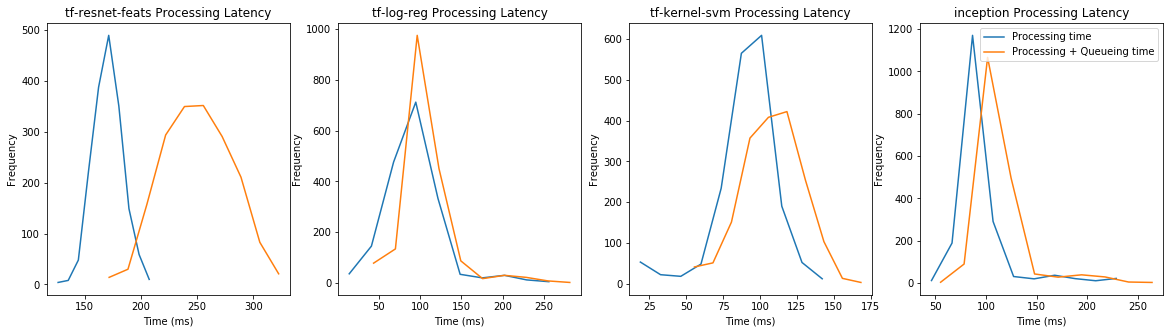

In [95]:
compare_latency_dists(ID1_500_unsaturated, image_driver_1_models)

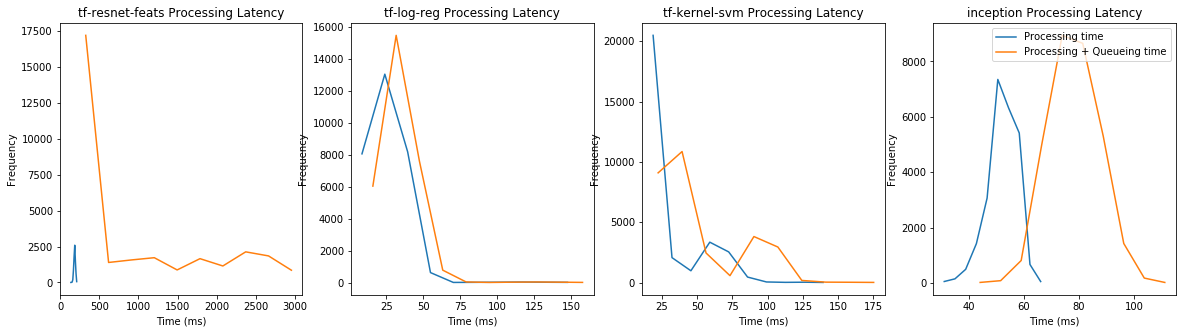

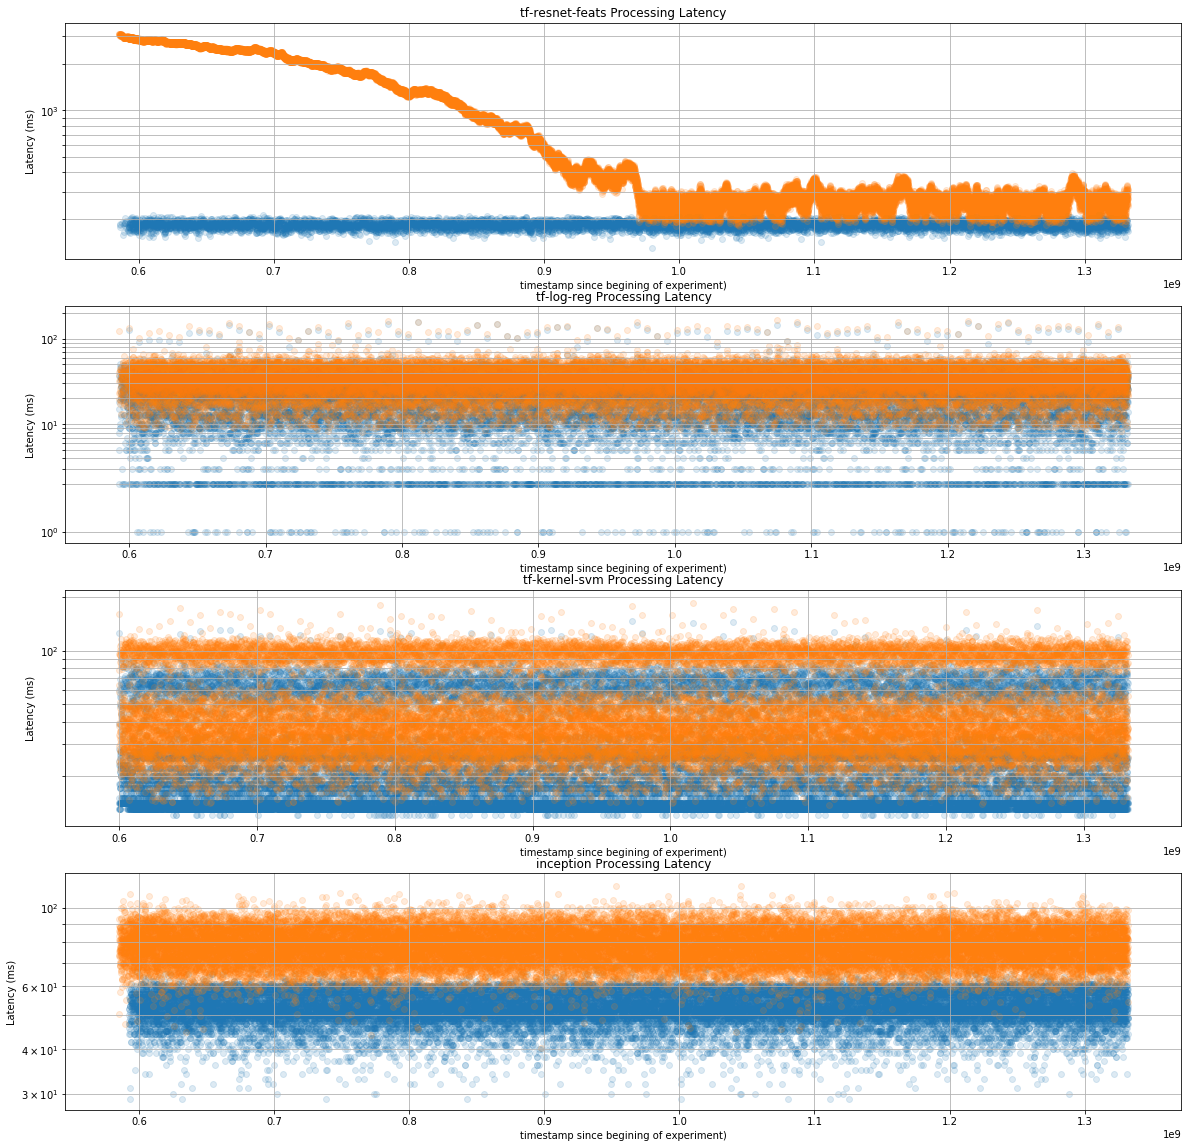

In [96]:
compare_latency_dists(ID1_500, image_driver_1_models)
compare_latency_dists_over_time(ID1_500, image_driver_1_models)

In [143]:
def plot_inter_arrival(cached_extractions, model_list):
    plt.figure(figsize=(8,8))
    plt.title("Inter-arrival time")
    plt.xlabel("Inter-arrival time (ms)")
    plt.ylabel("Frequency")
    for model in model_list:
        arrivals = cached_extractions[model+":1:queue_arrivals"][:,1]
        arrivals = np.sort(arrivals)
        intervals = arrivals[1:] - arrivals[:-1]
        intervals = intervals/1000 # to ms
        CV = np.square(np.var(intervals)/np.mean(intervals))
        lineHistogram(intervals, label=model+str(" CV="+str(CV)))
    plt.legend()

def plot_inter_arrival_over_time(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        arrivals = cached_extractions[model+":1:queue_arrivals"][:,1]
        arrivals = np.sort(arrivals)
        timestamps = cached_extractions[model+":1:queue_arrivals"][:,0]
        intervals = arrivals[1:] - arrivals[:-1]
        intervals = intervals/1000 # to ms
        CV = np.square(np.var(intervals)/np.mean(intervals))
        plt.title(model+" Inter-arrival time")
        plt.xlabel("Position")
        plt.ylabel("Inter-arrival time (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([np.min(intervals), np.max(intervals)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps[1:], intervals, label="CV="+str(CV), alpha = 0.3)
        plt.legend()

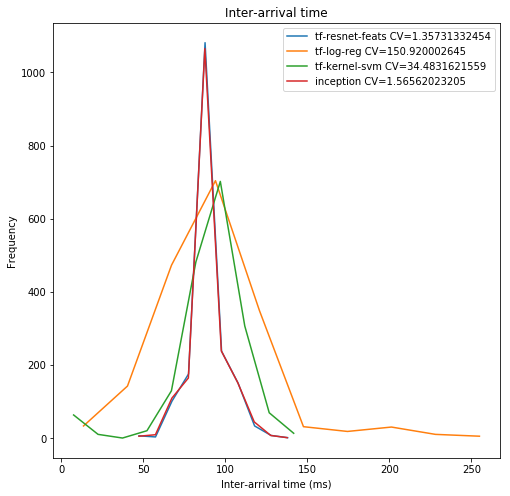

In [139]:
plot_inter_arrival(ID1_500_unsaturated, image_driver_1_models)

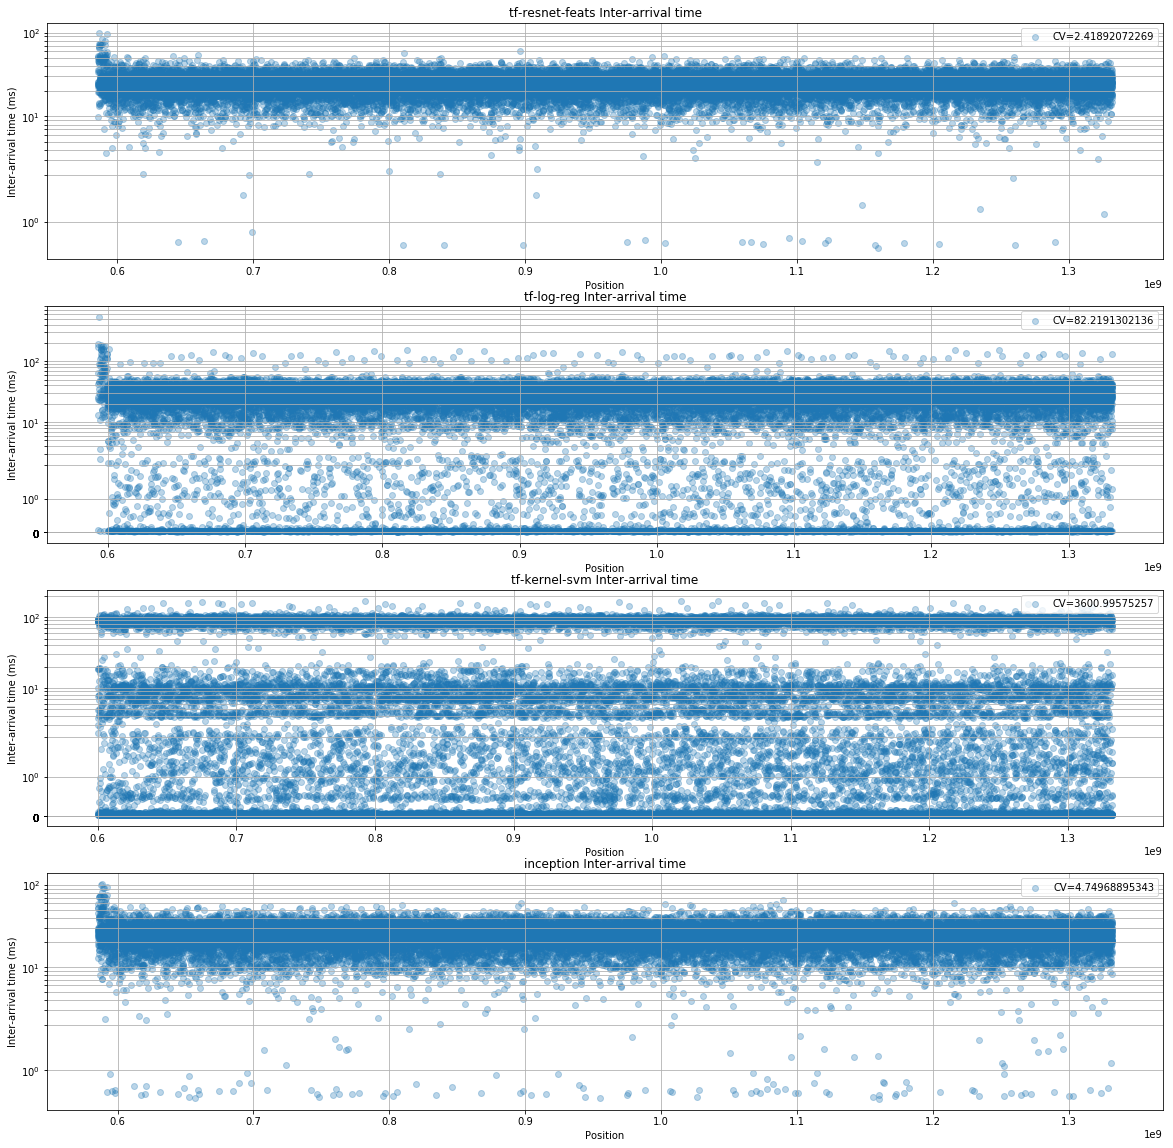

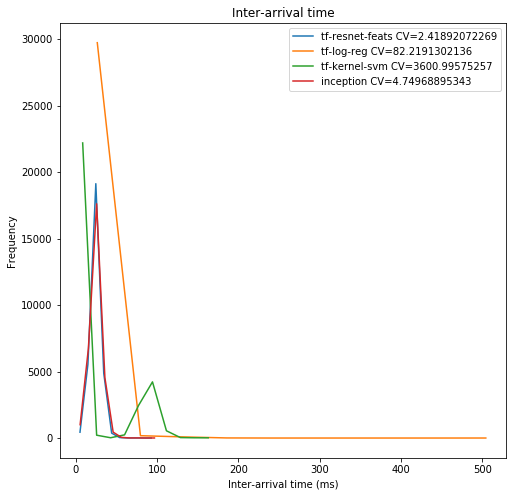

In [144]:
plot_inter_arrival_over_time(ID1_500, image_driver_1_models)
plot_inter_arrival(ID1_500, image_driver_1_models)

In [23]:
def plot_queue_sizes(cached_extractions, model_list, log=False):
    plt.figure(figsize=(8,8))
    plt.title("Queue length")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    if log:
        plt.xscale("log")
    for model in model_list:
        sizes = cached_extractions[model+":1:queue_sizes"]
        plt.hist(sizes, label=model,alpha=0.3)
    plt.legend()
    
def plot_ordinal_queue_sizes(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        sizes = cached_extractions[model+":1:queue_sizes"][:,1]
        timestamps = cached_extractions[model+":1:queue_sizes"][:,0]
        plt.title(model+" Queue length")
        plt.xlabel("Position")
        plt.ylabel("Length")
        needlog = np.max(sizes) - np.min(sizes) > 10
        bounds = np.asarray([np.min(sizes), np.max(sizes)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, sizes, label=model, alpha = 0.3)

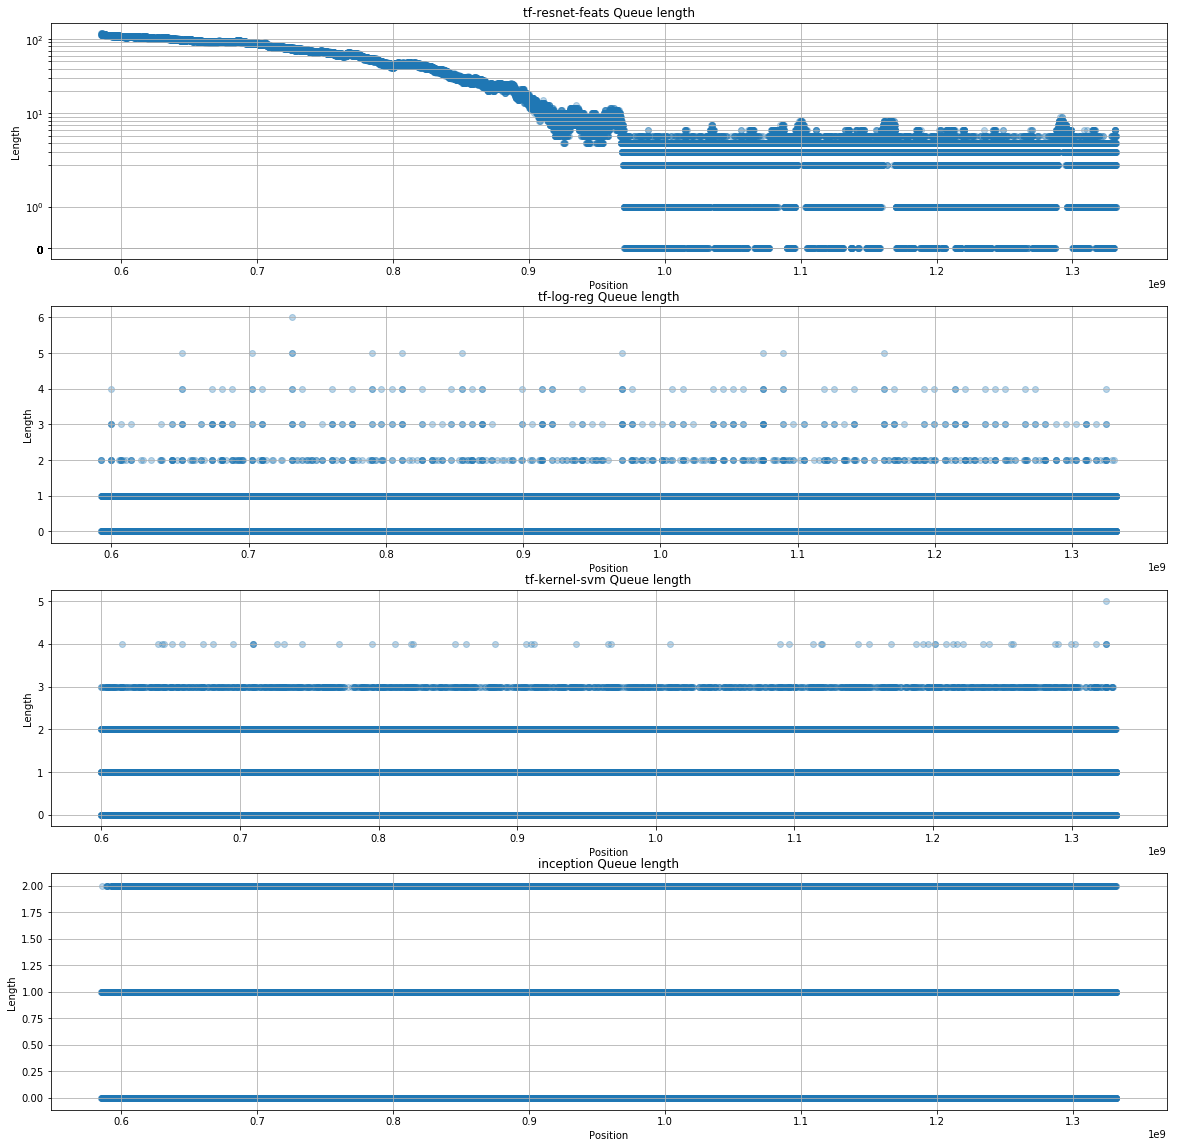

In [141]:
plot_ordinal_queue_sizes(ID1_500, image_driver_1_models)

In [129]:
def plot_e2e_lats(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Latencies")
    lats = cached_extractions["e2e_lats"]
    plt.plot(np.arange(len(lats)), lats)
    plt.xlabel("Experiment iteration")
    plt.axhline(y=0.5, color='r', linestyle='--', )
    plt.ylabel("Latency (ms)")

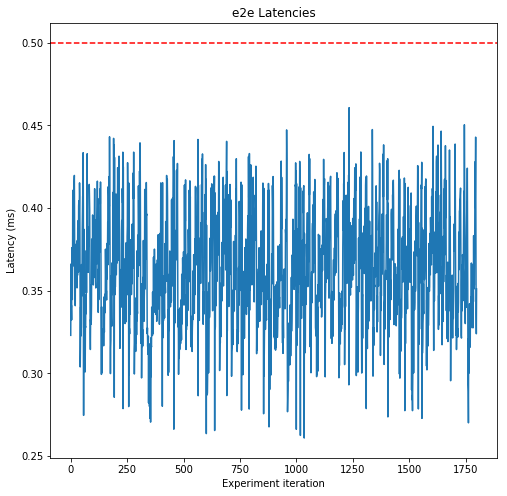

In [130]:
plot_e2e_lats(ID1_500_unsaturated_hollistic)

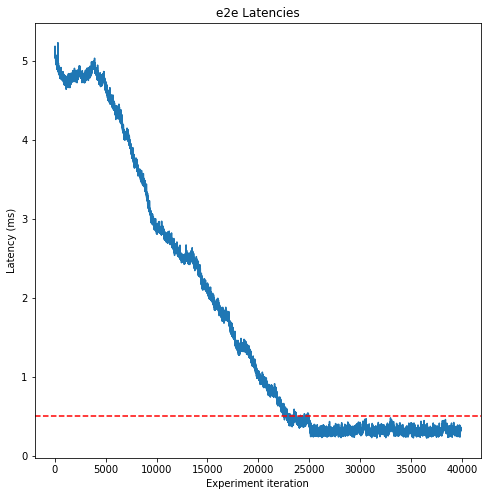

In [131]:
plot_e2e_lats(ID1_500_hollistic)